In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import opticsRayTrace.rayTraceTools as rtt
import opticsRayTrace.drawing as rtd
import opticsRayTrace.optimize as rto

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Zeroth, set up the minimal system

Every system needs a beginning and an end, so the minimal system has two surfaces. 

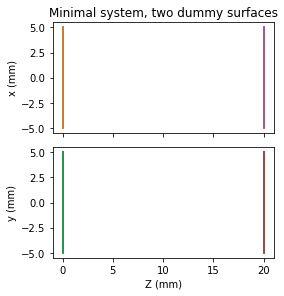

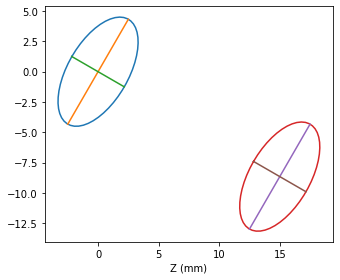

In [3]:
working_distance = 20
pupil_radius = 5

surface_list_1 = [
    {
        "surf": "dummy", 
        "dist": working_distance, 
        "draw_radius": pupil_radius
    },
    {
        "surf": "dummy", 
        "draw_radius": pupil_radius
    }
]

# The "geometry" takes the list of surfaces and works out their positions and
# orientations in space. Basically it adds details to the surface list, that
# will be needed by ray tracing.

geometry_1 = rtt.build_geometry(surface_list_1)

# My plotting tools are crude right now, just the ability to see X and Y
# projections of the system.

axd = rtd.new_plot()
rtd.plot_faces(axd, geometry_1)
axd["axs"][0].set_title("Minimal system, two dummy surfaces")
axd = rtd.new_plot(["3d"])
rtd.plot_faces(axd, geometry_1)

# First, need some rays to trace

I will start with 3 rays emanating from a point. That's enough to begin having fun, and also explain some terms.

**Coordinates** are (x, y, z) with z being the typical "optical axis." The calculations work best with rays that travel roughly parallel to the z-axis, though the only strict requirement is to avoid rays that are perpendicular to the z-axis.

**Finite** system means that the light source is in a specific known location. Points on the light source can be modeled as points in space, called **field points**.

**Infinite** system means that the light source is a great distance away, effectively infinity. Instead of points on the light source, we use vectors that determine the direction of rays coming from the source, called **field vectors**. These correspond to "field angles" in the optics design packages -- vectors express angles.

**Pupil** is the location where a ray enters your optical system. Once you have a field point or vector, and a pupil point, you have specified a ray.

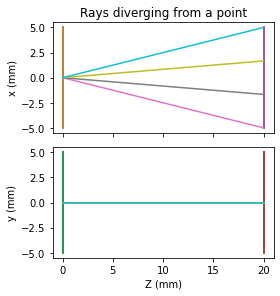

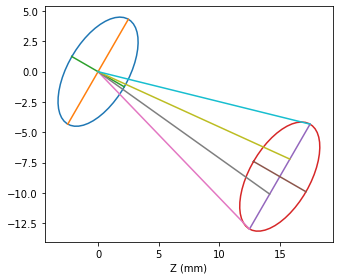

In [4]:
# Create a single field point

lsf = [0] #np.linspace(-1, 1, 3)
lsp = np.linspace(-pupil_radius, pupil_radius, 4)
field_points = np.array([[x, 0, 0] for x in lsf])
pupil_points = np.array([np.array([x, 0, working_distance]) for x in lsp])
wavelengths = np.array([0.000633])

# "Ray table" is a table that records the progress of each ray through the geometry. We start
# by creating an empty ray table that puts all of the surfaces in their correct locations.
# Remember, we already have "geometry" from above.

ray_table_1 = rtt.new_ray_table(geometry_1, field_points, pupil_points, wavelengths, infinite = False)

# This is the actual ray tracing

rtt.trace_rays(ray_table_1, geometry_1)

# The rest is just displaying the drawings

axd = rtd.new_plot()
rtd.plot_faces(axd, geometry_1)
rtd.plot_rays(axd, geometry_1, ray_table_1)
axd["axs"][0].set_title("Rays diverging from a point")

axd = rtd.new_plot(["3d"])
rtd.plot_faces(axd, geometry_1)
rtd.plot_rays(axd, geometry_1, ray_table_1)

## Playing with a simple lens
I'm going to borrow an achromatic doublet lens from the Edmund Optics catalog, just to have something to play with.
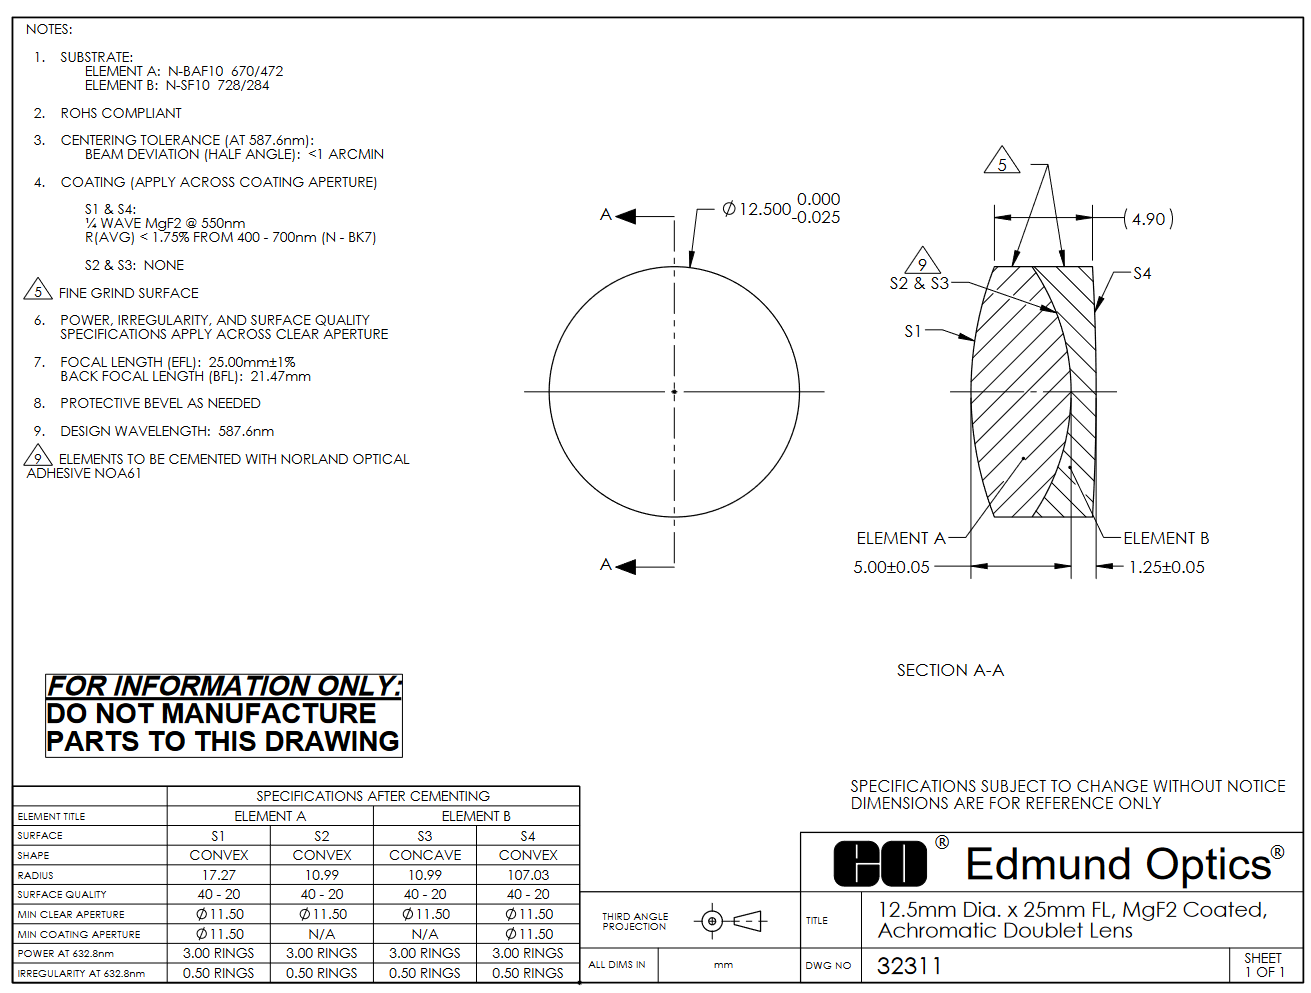

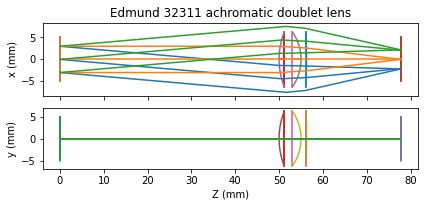

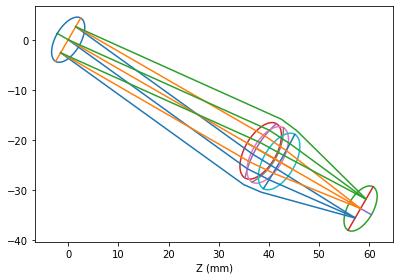

In [5]:
working_distance = 50

surface_list_2 = [
    {
        "surf": "dummy", 
        "dist": working_distance, 
        "draw_radius": 5
    },
    {
        "surf": "conic",
        "R": 17.27,
        "k": 0,
        "dist": 5,
        "material": "N-BAF10",
        "draw_radius": 6.26,
        "stop": True
    },
    {
        "surf": "conic",
        "R": -10.99,
        "k": 0,
        "dist": 1.25,
        "material": "N-SF10",
        "draw_radius": 6.26
    },
    {
        "surf": "conic",
        "R": -107.03,
        "k": 0,
        "dist": 21.47,
        "draw_radius": 6.26
    },
    {
        "surf": "dummy", 
        "draw_radius": 5
    }
]

geometry_2 = rtt.build_geometry(surface_list_2)

lsf = np.linspace(-5, 5, 3)*np.pi/180
lsp = np.linspace(-3, 3, 3)
fields = np.array([[np.sin(x), 0, np.cos(x)] for x in lsf])
pupils = np.array([[x, 0, 0] for x in lsp])
wavelengths = np.array([0.000633])

# "Ray table" is a table that records the progress of each ray through the geometry. We start
# by creating an empty ray table that puts all of the surfaces in their correct locations.
# Remember, we already have "geometry" from above.

ray_table_2 = rtt.new_ray_table(geometry_2, fields, pupils, wavelengths, infinite = True)
rtt.trace_rays(ray_table_2, geometry_2)
axd = rtd.new_plot()
rtd.plot_faces(axd, geometry_2)
rtd.plot_rays(axd, geometry_2, ray_table_2, color_by = 'field')
axd["axs"][0].set_title("Edmund 32311 achromatic doublet lens")
axd = rtd.new_plot(["3d"])
rtd.plot_faces(axd, geometry_2)
rtd.plot_rays(axd, geometry_2, ray_table_2, color_by = 'field')

## Using ray aiming

**Problem**: Its really hard to visualize what's going on. The rays at the starting surface (on the left, according to tradition) look like point sources, but they are intended to look like 3 sets of parallel rays. *Follow the colors*, one color for each field angle. Also notice that although my entrance aperture is smaller than the diameter of the lens, by the time the rays reach the lens, they are over-filling it. Also notice that the program happily traces rays that miss the surfaces as drawn. The reason is that drawing an ray tracing are completely independent of one another, and I haven't added a feature to suppress rays that miss the apertures of the optics.

For now, we need to proceed with a rule: Don't over-fill your apertures.

**Root cause**: The program is using the first surface as the entrance aperture, whereas it would be preferable to let the lens itself be the aperture.

**Solution is "ray aiming"**: We need to translate the rays from each field, so that they retain their original angles but so that each field is centered on a preferred aperture, which is identified as "stop" in the surface list. *The commercial packages have multiple ray aiming methods* but for now I'm going to choose a simplistic method. I'm going to apply a translation to the pupil positions for each ray based on its field value, like this:

$p_x \rightarrow p_x + a + b\cdot f_x + c \cdot f_y$

$p_y \rightarrow p_y + d + e \cdot f_x + f \cdot f_y$

where $(p_x, p_y, 0)$ is the pupil location, and $(f_x, f_y, \sqrt{(f_x**2 + f_y**2)})$ is the field vector. In other words the "pupil shift" will be a linear function of the field position or angle. Moreover, my program is going to compute the consts $(a, b, ... )$ by tracing a bunch of random rays through the system, and minimizing the average position of the rays at the stop surface. In fact I'll do this with the scipy.optimize.minimize() function. This is now built into my library.

Let's try it!

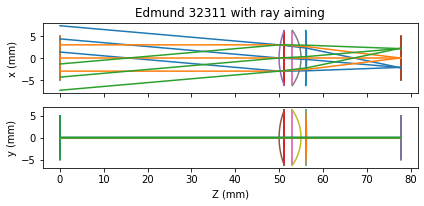

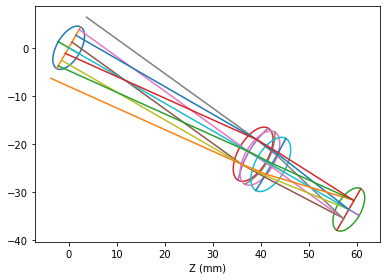

In [7]:
lsf = np.linspace(-5, 5, 3)
lsp = np.linspace(-3, 3, 3)
fields = np.array([np.array([x*np.pi/180, 0, 1]) for x in lsf])
pupils = np.array([np.array([x, 0, 0]) for x in lsp])
wavls = np.array([0.000633])

# "Ray table" is a table that records the progress of each ray through the geometry. We start
# by creating an empty ray table that puts all of the surfaces in their correct locations.
# Remember, we already have "geometry" from above.

aim_consts = rto.ray_aiming(geometry_2, wavelengths, True)
ray_table_2 = rtt.new_ray_table(geometry_2, fields, pupils, wavelengths, aim_consts = aim_consts, infinite = True)
rtt.trace_rays(ray_table_2, geometry_2)
axd = rtd.new_plot()
rtd.plot_faces(axd, geometry_2)
rtd.plot_rays(axd, geometry_2, ray_table_2,color_by = 'field')
axd["axs"][0].set_title("Edmund 32311 with ray aiming")
axd = rtd.new_plot(["3d"])
rtd.plot_faces(axd, geometry_2)
rtd.plot_rays(axd, geometry_2, ray_table_2)

Now you can see that each "field" of rays, which is presumably coming from somewhere far away, is adjusted to pass precisely through the so called "stop" aperture that I defined in the surface list. The lens is now big enough for the job.

Is this optically realistic? Sure. The reason is that it's common to design an imaging lens for a light source that's far away (such as the stars) by treating the rays from each point on the source as a bundle of parallel rays. And some kind of aperture, if not the lens itself, is defining the bundle of rays that are actually captured and brought to the focal plane. Indeed, the field-of-view of something like a telescope is defined in angular terms, not spatial terms, for this reason.